<a href="https://colab.research.google.com/github/Tsutomu-dayoo/DNN_lerning/blob/master/Theory2_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

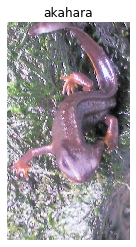

In [90]:
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import copy

np.random.seed(0)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

lr = 0.1

class FullyConnectedLayer():
  def __init__(self, in_n, out_n, use_bias=True, activation=None):#入力、出力、バイアス、活性化関数
    self.w = np.random.normal(0,1,[in_n, out_n])
    if use_bias:
      self.b = np.random.normal(0,1,[out_n])
    else:
      self.b = None
    if activation is not None:
      self.activation = activation
    else:
      self.activation = None
      
  def forward(self, feature_in):
    self.x_in = feature_in
    z = np.dot(feature_in,self.w)
    if self.b is not None:
      z += self.b
    if self.activation is not None:
      x = self.activation(z)
      self.x_out = x

    return x
  
  def backward(self, w_pro, grad_pro):
      grad = np.dot(grad_pro, w_pro.T)
      if self.activation is sigmoid:
        grad *= (self.x_out * (1 - self.x_out))
      grad_w = np.dot(self.x_in.T, grad)
      self.w -= lr * grad_w

      if self.b is not None:
        grad_b = np.dot(np.ones([grad.shape[0]]), grad)
        self.b -= lr * grad_b

      return grad

class Model():
  def __init__(self, *args):
    self.layers = args #設定したレイヤーの数だけ層を作る

  def forward(self, x):
    for layer in self.layers: #;for layer<-ここで宣言してる
      x = layer.forward(x)#順伝播
      self.output = x

    return x

  def backward(self, t):
    En = (self.output - t) * self.output * (1 - self.output)
    grad_pro = En
    w_pro = np.eye(En.shape[-1])
        
    for i, layer in enumerate(self.layers[::-1]):
            grad_pro = layer.backward(w_pro=w_pro, grad_pro=grad_pro)
            w_pro = layer.w

num_classes = 2
img_height, img_width = 64, 64

CLS = ['akahara', 'madara'] #akahara->0, madara->1
path = 'drive/My Drive/images/'

def data_load(path, hf = False, vf = False, rot = False): #hf:左右反転、vf:上下反転、rot;回転
    xs = []
    ts = []
    paths = []

    for dir_path in glob(path + '/*'):
      for path in glob(dir_path + '/*'):
        x = cv2.imread(path)
        x = cv2.resize(x, (img_width, img_height)).astype(np.float32)
        x /= 255. #255で割って[0,1]の間に正規化する
        xs.append(x) #画像情報を配列化
        x2 = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        for i, cls in enumerate(CLS): #akahara->0, madara->1　インデックスと要素を取得
          if cls in path:#要素の名前と同じファイル名があればその数字でラベル付け
            t = i
            ts.append(t)#対応するラベルを配列化

            paths.append(path)#対応するラベルを配列化

            if hf:#左右反転なのでピクセルの列を逆から取得して配置すればいい
              xs.append(x[:,::-1])
              ts.append(t)
              paths.append(path)
            if vf:#上下反転なのでピクセルの行を逆から取得して配置
              xs.append(x[::-1])
              ts.append(t)
              paths.append(path)
            if hf and vf:
              xs.append(x[::-1, ::-1])
              ts.append(t)
              paths.append(path)
            if rot != False:
              angle = rot
              scale = 1

              # show
              a_num = 360 // rot#//で割り算の商のみを取得
              w_num = np.ceil(np.sqrt(a_num))
              h_num = np.ceil(a_num / w_num)
              count = 1
              """
              plt.subplot(h_num, w_num, count)
              plt.axis('off')
              plt.imshow(x)
              plt.title("angle=0")
              """

              while angle < 360:
                _w,_h,_c = x.shape#横、縦、RGMを取得
                max_size = max(_w,_h)
                tem = np.zeros((max_size,max_size,_c))#０で初期化
                tx = int((max_size - _w) / 2)
                ty = int((max_size - _h) / 2)
                tem[ty: ty+_h, tx: tx+_w] = x.copy()
                M = cv2.getRotationMatrix2D((max_size/2,max_size/2),angle,1)#cv2.getRotationMatrix2D((回転の中心),回転角度,倍率)
                _x = cv2.warpAffine(tem,M,(max_size,max_size))
                _x = _x[tx:tx+_w,ty:ty+_h]
                xs.append(x)
                ts.append(t)
                paths.append(path)

                # show
                count += 1
                """
                plt.subplot(h_num, w_num, count)
                plt.imshow(_x)
                plt.axis('off')
                plt.title("angle={}".format(angle))
"""
                angle += rot
            #plt.show()
    ts = [[t] for t in ts]#行列化
    xs = np.array(xs, dtype=np.float32)#行列化
    ts = np.array(ts, dtype=np.int)
    xs = xs.transpose(0,3,1,2)

    return xs, ts, paths

model = Model(FullyConnectedLayer(in_n=img_height * img_width * 3, out_n=64, activation=sigmoid),
              FullyConnectedLayer(in_n=64, out_n=32, activation=sigmoid),
              FullyConnectedLayer(in_n=32, out_n=1, activation=sigmoid))

xs, ts, paths = data_load('drive/My Drive/images/',hf=False,vf=False,rot=30)

mb = 64#ミニバッチの数
mbi = 0
train_ind = np.arange(len(paths))#data数を数える
np.random.shuffle(train_ind)#引数をランダムにして元の引数に戻す、この場合はtrain_indをそのまま使える

for ite in range(1000):
  if mbi + mb > len(xs):
      mb_ind = copy.copy(train_ind)[mbi:]
      np.random.shuffle(train_ind)
      mb_ind = np.hstack((mb_ind, train_ind[:(mb-(len(xs)-mbi))]))
      mbi = mb - (len(xs) - mbi)
  else:
      mb_ind = train_ind[mbi: mbi+mb]
      mbi += mb

  x = xs[mb_ind]
  t = ts[mb_ind]
  x = x.reshape(mb, -1)
  model.forward(x)
  model.backward(t)

#test
xs, ts, paths = data_load('drive/My Drive/images/',hf=False,vf=False,rot=False)

for i in range(len(xs)):
  x = xs[i]
  x = x.reshape(1, -1)
  out = model.forward(x)
  if out >= 0.5:
    name = 'madara'
  else:
    name = 'akahara'
  
  img = cv2.imread(paths[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(img)
  plt.title(name)

#plt.show()